In [1]:
import os

import numpy as np

import cv2 as cv

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from PIL import Image

from IPython.display import display

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
from torchinfo import summary
from tqdm import tqdm

- `import os`: Provides methods for interacting with the operating system.
- `import numpy as np`: Numerical Python under the `np` alias. Universal standard for working with numerical data.
- `import cv2 as cv`: OpenCv; Open-Sournce Computer Vision library under the `cv` alias. Provides numerous computer vision algorithms.
- `import matplotlib.pyplot as plt`: Most of Matplotlib utilities under the `plt` alias.
- `import matplotlib.image as mpimg`: Basic image loading, rescaling and display.
- `%matplotlib inline`: Enables inline plotting, where plotted graphics appear in your notebook.
- `from PIL import Image`: Image module of Python Imaging Library.
- `from IPython.display import display`: Public API for display tools in IPython.
- `import torch`: PyTorch; Tensor computation with strong GPU acceleration.
- `import torch.nn as nn`: Pytorch module under `nn` alias, for neural network creation and training.
- `import torch.nn.functional as F`: Convolution, pooling, activation and attention functions under the `F` alias.
- `from torch.utils.data import DataLoader`: Python iterable over a dataset.
- `from torchvision import datasets, transforms, models`: Popular datasets, model architectures, and common image transformations for computer vision.
- `from torch.optim.lr_scheduler import StepLR`: `SteLR` scheduler in PyTorch, is used for adjusting the learning rate during training. It is a simple scheduler that multiplies the learning rate by a given factor (`gamma`) every specified number (`step_size`) of epochs.
- `from torchinfo import summary`: `summary` is a utility for providing detailed information about PyTorch models. *The original project used `summary` from `torchsummary`. Apparently this is deprecated, so I chose `torchinfo` instead.*
- `from tqdm import tqdm`: Show a smart progress meter.

### Data:

• *Steps*

-  Create an image classifier over a dataset of x-ray images of lungs with pneumonia and normal lungs.
-  Download dataset and place in local directory, accessible by the Python compiler. We will use open source data, found at: *[Xrays](https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images)*
-  The dataset is divided into *test* and *train* folders, each further divided into NORMAL and PNEUMONIA categories.

   - *The number of train samples in the NORMAL category is 1349.*
   - *The number of train samples in the PNEUMONIA category is 3883*
   - *The number of test samples in the NORMAL category is 234*
   - *The number of test samples in the PNEUMONIA category is 390*

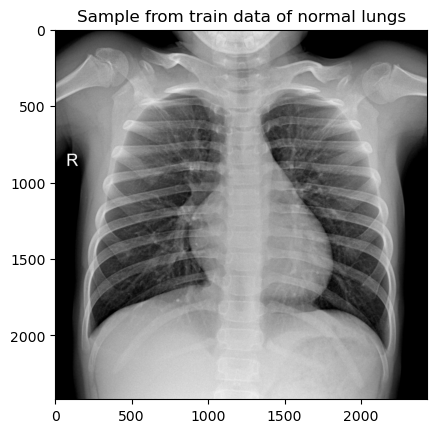

In [2]:
img_1 = cv.imread(r'img/chest_xray/train/NORMAL/NORMAL-28501-0001.jpeg')
plt.imshow(img_1)
plt.title('Sample from train data of normal lungs')
plt.show()

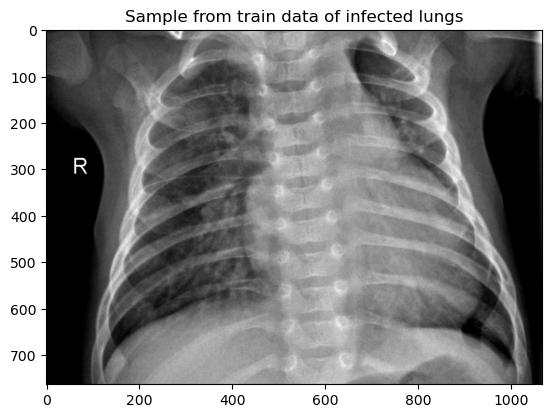

In [3]:
img_2 = cv.imread(r'img/chest_xray/train/PNEUMONIA/BACTERIA-7422-0001.jpeg')
plt.imshow(img_2)
plt.title('Sample from train data of infected lungs')
plt.show()

- `cv.imread()` from OpenCv.
- `plt.show()` from matplotlib.

#### On imports:

 GPU is better for a faster process but CPU should also work. We need to install PyTorch, with CUDA support, in case we are using local CUDA cores. We need to be carefull about all the objects placed in CUDA for processing and all the objects placed in the CPU for processing.

 *The intermingling of data across different processor types is not supported unless they are specifically cast*. 

 *The custom libraries required for these classification problems have been listed in the beginning of this notebook*


Finally we set a data path for the data directory:


In [4]:
data_path = 'img\chest_xray'

- `data_path`: Is the variable in which we store the relative path for the images.

### Data Exploration:

 We will now explore and check the sanity of the data. We have to assign *train* and *test* folders that can be used in the model. We can use the folder name as the class name if the images are segregated by folders. (*There can be another variation where we can see all images in one folder and then specify which image path belongs to which class.*)

In [5]:
class_name = ['NORMAL', 'PNEUMONIA']
def get_list_files(dirName):
    '''
    input - directory location
    output - list the files in the directory
    '''
    files_list = os.listdir(dirName)
    return files_list

- `class_name = ['NORMAL', 'PNEUMONIA']`: Creates a list named `class_name` containing two class labels, 'NORMAL' and 'PNEUMONIA'.
- Define the function with `dirName` argument. Takes a directory path `(dirName)` as input and returns a list of files present in that directory using `os.listdir.`  
- `os.listdir(dirName)`: Returns the list of all files and directories in the specified directory.
- `return files_list`: Returns the list of file names as the output of the function.

 We will now call the `get_list_files()` function to see the number of test samples:

In [6]:
files_list_normal_train = get_list_files(data_path + '/train/' + class_name[0])
print(f'Train samples in Normal category: {len(files_list_normal_train)}')

files_list_pneumonia_train = get_list_files(data_path + '/train/' + class_name[1])
print(f'Train samples in Pneumonia category: {len(files_list_pneumonia_train)}')

files_list_normal_test = get_list_files(data_path + '/test/' + class_name[0])
print(f'Test samples in Normal category: {len(files_list_normal_test)}')

files_list_pneumonia_test = get_list_files(data_path + '/test/' + class_name[1])
print(f'Test samples in Pneumonia category: {len(files_list_pneumonia_test)}')


Train samples in Normal category: 1349
Train samples in Pneumonia category: 3883
Test samples in Normal category: 234
Test samples in Pneumonia category: 390


- `class_name[0]` is the $0$ index item in the `class_name` list i.e `class_name[0]` = 'NORMAL', `class_name[1]` = 'PNEUMONIA'

View samples:

*Now that we have counted the images and located their path, let's see how to view the sample images from NORMAL and PNEUMONIA folders:*

Image dimensions: (950, 1264)


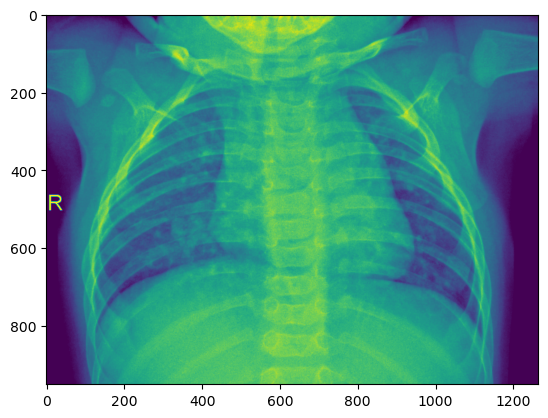

In [7]:
rand_img_no = np.random.randint(0,len(files_list_normal_train))
img = data_path + '/train/NORMAL/' + files_list_normal_train[rand_img_no]
print(f'Image dimensions: {plt.imread(img).shape}')
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

- define `rand_img_no` variable with `np.random.randint` that returns random integers. 
- `np.random.randint(0,len(files_list_normal_train))` generates a random integer using Numpy's `randint` function. The first argument `(0)` is the inclusive lower bound, and the second argument `(len(files_list_normal_train))` is the exclusive upper bound. It means the random integer can be any value from 0 to the length of `files_list_normal_train` minus 1. $[x,y)$
- `img` variable, contains the full file path to a randomly selected image from the 'NORMAL' class in the training set.
- `imread().shape`: Retrieves the dimensions *(shape)* of the image.
- `mpimg.imread(img)`: Reads the image with Matplotlib.
- `plt.imshow(img)`: Displays the image with imshow.
- `plt.show()`: Shows the image; without this, the image would be created but not displayed.

### Data Loader:
 
Now that we have explored the data, let's setup the data loaders for training purposes. We will crop and resize the images to a uniform size of $224x224$. This is not set in stone, a different size can be used.  
We will also convert the images to tensors for the PyTorch framework. We will try to normalize the images with mean and standard deviation values. *Subtracting the mean centers the input to 0, and dividing by the standard deviation makes any feature values scale by a number of standard deviations away from the mean.* $z=\frac{ x - μ}{σ}$ . *[Details.](https://stats.stackexchange.com/questions/185853/why-do-we-need-to-normalize-the-images-before-we-put-them-into-cnn#185857)*  
If we are considering three channels per image, then we need to provide three values for one channel. We need one combination of mean and standard deviation.

In [8]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])

- `transforms.Resize(224)`: Resizes the image to have a minimum size of 224. If the image is smaller than this size, it will be scaled up. If it's larger, it will be scaled down.
- `transforms.CenterCrop(224)`: Performs a center crop on the image, extracting a square region of size 224x224 pixels. This is often used to create square input images.
- `transforms.ToTensor()`: Converts the image to a PyTorch tensor. PyTorch tensors are the primary data structure used in PyTorch for storing and manipulating multi-dimensional arrays.
- `transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])`: Normalizes the tensor. This involves subtracting the mean and dividing by the standard deviation. The values `[0.485, 0.456, 0.406]` and `[0.229, 0.224, 0.225]` are the mean and standard deviation values for the three color channels (RGB). These *specific values* are often used for normalization when working with models pretrained on large datasets like ImageNet. *[Details](https://stackoverflow.com/questions/65676151/how-does-torchvision-transforms-normalize-operate)*.
- The `transforms.Compose` function is then used to combine these transformations into a single transform that can be applied to an image.

> *Normalizing data includes them in the same range as our activation functions, usually between 0 and 1. This allows for less frequent non-zero gradients during training, and therefore the neurons in our network will learn faster. By normalizing each channel so that they have the same distribution, we ensure that the channel information can be mixed and updated during the gradient descent (back propagation) using the same learning rate.*

In [9]:
train_data = datasets.ImageFolder(
    os.path.join(data_path, 'train'), transform=train_transform
    )
test_data = datasets.ImageFolder(
    os.path.join(data_path, 'test'), transform=test_transform
    )

- `train_data` and `test_data` are instances of the `Imagefolder` class representing the training and testing datasets, respectively. These will be used with PyTorch's `Dataloader` for iterating through batches during training or evaluation.
- `ImageFolder` class, automatically assigns labels to images based on the subdirectory they are in.
- The `os.path.join(data_path, 'train/test')` command is used to create a path by joining the data_path variable with the subdirectory `'train/test'`.
- The `transform` argument applies the specified transformations.

In [10]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, pin_memory=True)
class_names =  train_data.classes
print(class_names)
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')

['NORMAL', 'PNEUMONIA']
Number of train images: 5232
Number of test images: 624


- `DataLoader`: PyTorch utility for loading and batching data.
- `train_loader`: Variable where `DataLoader` stores the (`train_data`) dataset.
- `test_loader`: Variable where `DataLoader` stores the (`test_data`) dataset.
- `batch_size`: Specifies the number of samples *(images)* in each mini-batch.
- `shuffle` is set to *True* only in the `train_loader`. This means that the data will be shuffled at the beginning of each epoch. This is essential in order to avoid the model learning patterns based on the order of the data. In the case of the testing data, the shuffle needs to be turned off.
- `pin_memory=True` pins/pushes data initially loaded in the CPU, to the GPU. The process is faster when pin memory is enabled. *[Details.](https://stackoverflow.com/questions/55563376/pytorch-how-does-pin-memory-work-in-dataloader#55564072)*
- `train_data.classes` contains the class labels (names) found in the dataset.With this we can see what classes the model is trained on.

> **Epoch**: An epoch in machine learning is one complete pass through the entire training dataset. One epoch is complete when the model has processed all the batches and
updated its parameters based on calculated loss (cost function).
*[Details.](https://www.geeksforgeeks.org/epoch-in-machine-learning/)*

To sum up: The `DataLoader` is configured to load the training data in mini-batches of size $16$ and the testing data in mini-batches of size $1$. This is common in machine learning, where training is often done in mini-batches for efficiency. The `shuffle` parameter is set to `True` for the training `DataLoader`, meaning that the data will be shuffled at the beginning of each epoch.

### Defining the Model:

The model architecture will be defined with convolution blocks and use `ReLU` as an activation layer. The baseline model will have 12 convolution blocks, including one convolution block to set up the input and one for the output. The first three have one `MaxPool` function, to reduce dimentions by filtering information.

<img src="img/VGG16.JPG" style="display:block; margin:auto">

*<p style="text-align: center;">Convolutional blocks, in a well-known CNN called VGG-16. [Source.](https://learnopencv.com/understanding-convolutional-neural-networks-cnn/)</p>*
- **Convolution Blocks**:  A convolutional block is a general term used to describe a sequence of layers in a CNN that are often repeatedly used in the feature extractor.
- **Pooling Layer**: This layer is usually added after the convolutional layer. Pooling layer reduces the spatial size of the output from convolutional layer and extracts dominant features.
  - · Max Pooling returns the maximum value from the portion of the image covered by kernel.
  - · Average Pooling returns the average value from the portion of the image covered by kernel.

<img src="img/max_pooling.JPG" style="display:block; margin:auto">

*<p style="text-align: center;">Max Pooling vs. Avg Pooling. [Source.](https://www.researchgate.net/figure/Toy-example-illustrating-the-drawbacks-of-max-pooling-and-average-pooling_fig2_300020038)</p>*

- **ReLU** (Rectified Linear Unit) function: 
  
  <img src="img/ReLU_form.JPG" style="display:block; margin:auto">

  *<p style="text-align: center;">ReLU definition. [Source.](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))</p>*
  
  <img src="img/ReLU.JPG" style="display:block; margin:auto">
*<p style="text-align: center;">Outputs the input directly if it is positive, otherwise, it will output zero. [Source.](https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7)</p>*
  

### *Model Definition*:

In [11]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()

        #INPUT BLOCK
        self.convblock1 = nn.Sequential(
            nn.Conv2d(
            in_channels=3, out_channels=8, kernel_size=(3,3),padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(4)
        )
        self.pool11 = nn.MaxPool2d(2,2)

        # CONVOLUTION BLOCK
        self.convblock2 = nn.Sequential(
            nn.Conv2d(
            in_channels=8, out_channels=16, kernel_size=(3,3),padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(16)
        )
        self.pool22 = nn.MaxPool2d(2,2)

        # TRANSITION BLOCK
        self.convblock3 = nn.Sequential(
            nn.Conv2d(
            in_channels=16, out_channels=10, kernel_size=(1,1), padding=0, bias=False),
            nn.ReLU()
            #nn.BatchNorm2d(10),
        )
        self.pool33 = nn.MaxPool2d(2,2)

        # CONVOLUTION BLOCK
        self.convblock4 = nn.Sequential(
            nn.Conv2d(
            in_channels=10, out_channels=10, kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(10)
        )
        self.convblock5 = nn.Sequential(
            nn.Conv2d(
            in_channels=10, out_channels=32, kernel_size=(1,1), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(32),
        )
        self.convblock6 = nn.Sequential(
            nn.Conv2d(
            in_channels=32, out_channels=10, kernel_size=(1,1), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(10),
        )
        self.convblock7 = nn.Sequential(
            nn.Conv2d(
            in_channels=10, out_channels=10, kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(10),
        )
        self.convblock8 = nn.Sequential(
            nn.Conv2d(
            in_channels=10, out_channels=32, kernel_size=(1,1), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(32),
        )
        self.convblock9 = nn.Sequential(
            nn.Conv2d(
            in_channels=32, out_channels=10, kernel_size=(1,1), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(10),
        )
        self.convblock10 = nn.Sequential(
            nn.Conv2d(
            in_channels=10, out_channels=14, kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(14),
        )
        self.convblock11 = nn.Sequential(
            nn.Conv2d(
            in_channels=14, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(16),
        )

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        )
        self.convblockout = nn.Sequential(
            nn.Conv2d(
            in_channels=16, out_channels=2, kernel_size=(4,4), padding=0, bias=False),
        )

    def forward(self,x):
        x = self.convblock1(x)
        x = self.pool11(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)
        x = self.convblockout(x)

        x = x.view(-1,2)
        return F.log_softmax(x, dim=-1)

The code above is a convolutional neural network class definition (CNN).  

```python
class Net(nn.Module):  
    def __init__(self):  
        super(Net, self).__init__()
```
- `class Net(nn.Module):` Defines a class named `Net`, that is a subclass of `nn.Module`.  
`Net` inherits the properties and methods of `nn.Module`, which is a base class for all neural network modules in PyTorch.
- The `__init__ `function is called a constructor, or initializer, and is automatically called when you create a new instance of a class.
- `self`: Suppose that a class named `ClassA` contains a method `methodA` is defined as:
  ```python
    class ClassA:
      def methodA(self, arg1, arg2):
          ... # do something
  ```
  Also, suppose that `objectA` is an *instance* of this class.
  Now when `objectA.methodA(arg1, arg2)` is called, python internally converts it as: `ClassA.methodA(objectA, arg1, arg2)`.  
  **The `self` variable refers to the object itself.**

- In Python, the `super()` function is used to refer to the parent *class* or *superclass*. It allows you to call methods defined in the superclass from the subclass, enabling you to extend and customize the functionality inherited from the parent class. *[Details](https://www.geeksforgeeks.org/python-super/)*. `super(Net, self).__init__()` is calling the constructor of the parent class (nn.Module). This is necessary to properly initialize the Net object as a PyTorch module.

- `convblock` is a combination of a $2D$ convolutional layer, followed by a `ReLU` activation function. 
  - `nn.Sequential`: Is a container for a sequence of layers. It applies each layer to the input data, in sequence. In this case, it first applies the convolutional layer and then the ReLU activation function.  *(Containers are any object that holds an arbitrary number of other objects. Generally, containers provide a way to access the contained objects and to iterate over them.)*
  - `nn.Conv2d`:  
    - `in_channels`: The number of input channels. $3$ is typical for RGB.
    - `out_channels`: The number of output channels, or the number of filters/kernels used in the convolution. Each filter produces one channel in the output.
    - `kernel_size`: The size of the convolutional filter/kernel.
    - `padding`: The amount of pixels added to an image when it is being processed by the kernel of a CNN. During convolution, the size of the output feature map is determined by the size of the input feature map, the size of the kernel, and the stride. if we simply apply the kernel on the input feature map, then the output feature map will be smaller than the input. This can result in the loss of information at the borders of the input feature map. In Order to preserve the border information we use padding. Padding involves adding extra pixels around the border of the input feature map before convolution. 
    - >For a grayscale $(nxn)$ image and $(fxf)$ filter/kernel, the dimentions of the image resulting from a convolution is: $(n-f+1)x(n-f+1)$. Thus the image *shrinks every time a convolution operation is performed.*


      <img src="img/padding.gif" style="display:block; margin:auto"> \
      
    - `bias`: For a typical neuron,  with $x_i$ inputs and $w_i$ weights, the output is: $y = f(x) = \sum x_i w_i$. This is the *weighted sum*. In simple words, neural network bias can be defined as the constant which is added to the dot product of features and weights. It is used to *offset the result*. It helps the models to **shift the activation function towards the positive or negative side**. The processing done by a neuron is thus denoted as : $output = \sum x_i w_i + bias$. *Details:* *[(1)](https://stackoverflow.com/questions/2480650/what-is-the-role-of-the-bias-in-neural-networks),[(2)](https://www.baeldung.com/cs/neural-networks-bias)*
  - `ReLU`: This is the rectified linear unit activation function. It introduces non-linearity to the model by outputting the input directly if it is positive; otherwise, it outputs zero.
- `self.gap`: This defines a Global Average Pooling (GAP) layer in the neural network.
    - `nn.AvgPool2d`:
      - `kernel_size`: This is the size of the window over which each pooling operation is performed.  
- `def forward()`: This method defines the *forward pass* of the neural network. It describes how the input data is proccessed trough the layers to produce the output.
  - `x.view(-1,2)`: This line reshapes the tensor to have a size of `(batch_size,2)`. This is typically done before feeding the data to the final activation function. $-1$ causes the function to infer the value for this dimention. `x.view(Height/Rows,Width/Columns)` [Details.](https://stackoverflow.com/questions/50792316/what-does-1-mean-in-pytorch-view/50793899#50793899) See also: *[Difference between reshape and view in PyTorch.](https://saturncloud.io/blog/whats-the-difference-between-reshape-and-view-in-pytorch/)*
- `return F.log_softmax(x, dim=-1)`: Is producing the final output of the neural network, after proccessing the input through the various convolutional and pooling layers.
    - `F.log_softmax`: This is a function from the `torch.nn.functional` module . It computes the logarithm of the softmax function. The log is taken to make the computation more numerically stable.
    - `dim=-1`: Specifies along which dimension the softmax sould be computed.$-1$ refers to the last diension.

### Model Explanation:
1. **The Input Block**: The model receives a three - channel $224x224$ input and uses a  convolution by $3x3$ to generate $222x222$ and $8$ channels. This is followed by the `ReLU` activation layer. No padding.  
2. **Convolution Block**: After the input, the `MaxPooling` function reduces the feature map size to $111x111$.
3. After the pooling function works on the feature maps, the feature maps are convolved by $3x3$  to generate $16$ channels from $8$ and reducing the feature map dimension to $109x109$.
4. After we get $16$ channels, we use the `MaxPooling` function again, to bring the feature map dimension to $54x54$.
5. **Transition Block**: Reduces the number of channels from $16$ to $10$, followed by another `MaxPooling` function.
6. **Convolution Block**: After `MaxPooling`, the feature map dimension is now $27x27$. A $3x3$ kernel is used to convolve and create an equal number of feature maps.
7. The fifth and sixth convolution blocks are transition layers, wherein we increase the  number of layers from $10$ to $32$ and back to $10$. There is no padding as usual for this.
8. The seventh convolution block is used for $3x3$ convolution operations, but the channel size remains the same again.
9. Similar operations in the eighth and ninth convolution blocks. Using the transition convolutional operations, the channels change from $10$ to $32$ and back to $10$ again.
10. A $3x3$ convolution block is added, which is tenth in line. The number of feature maps is increased from $10$ to $14$.
11. The penultimate building block of the architecture is using a $3x3$ kernel to move the  number of channels from $14$ to $16$.
12. **Output Block**: In the output block, we use average pooling (`AvgPool2d`) to downsample. This can be used for the binary classification. Following our average pooling, we use a convolution block of the same kernel size as of the feature map dimension  to bring that into a single unit for the output. *(It reduces the spatial dimensions to $1x1$, taking the average value over each feature map. Global average pooling is often used as a replacement for fully connected layers in the final layers of  convolutional neural networks.)*
13. Finally, we use the logarithmic `log_softmax` function to produce the output. It applies the standard exponential function to each element $z_{i}$ of the input vector $z$ and normalizes these values by dividing by the sum of all these exponentials. The normalization ensures that the sum of the components of the output vector σ (z) is 1. [Details.](https://stackoverflow.com/questions/49036993/pytorch-softmax-what-dimension-to-use)
    
<img src="img/softmax.JPG" style="display:block; margin:auto">  



We can output the model in a GPU and see its summary:

In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print(f'Avaliable processor: {device}')
model = Net().to(device)
summary(model, input_size=(3,224,224), col_names=('output_size', 'num_params'))


Avaliable processor: cuda


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 2]                    --
├─Sequential: 1-1                        [8, 222, 222]             --
│    └─Conv2d: 2-1                       [8, 222, 222]             216
│    └─ReLU: 2-2                         [8, 222, 222]             --
├─MaxPool2d: 1-2                         [8, 111, 111]             --
├─Sequential: 1-3                        [16, 109, 109]            --
│    └─Conv2d: 2-3                       [16, 109, 109]            1,152
│    └─ReLU: 2-4                         [16, 109, 109]            --
├─MaxPool2d: 1-4                         [16, 54, 54]              --
├─Sequential: 1-5                        [10, 54, 54]              --
│    └─Conv2d: 2-5                       [10, 54, 54]              160
│    └─ReLU: 2-6                         [10, 54, 54]              --
├─MaxPool2d: 1-6                         [10, 27, 27]              --
├─Sequenti

- `Layer (type:depth-idx):` Type and depth index of each layer.
- `Output Shape:` Shape of the output tensor after each layer. For example, $[8, 222, 222]$ means a tensor of shape ($8$ channels, $222$ height, $222$ width).
- `Param #:` The number of parameters (weights and biases) for each layer.
- `Total params`: Total number of parameters, both trainable and not trainable.
- `Trainable params`: These will be updated during training.
- `Non-trainable params`: Usually associated with operations like barch normalization, where the mean and variance are not updated during training.
- `Total mult-adds (M)`: Estimated total of multiply-add operations im millions in a forward pass of the network. It's a measure of computational complexity.
- `Input size (MB)`: Memory required for the input data.
- `Forward/backward pass size (MB)`: Memory required for storing intermediate values during forward/backward passes.
- `Params size (MB)`: Memory required to store the parameters.
- `Estimated Total Size (MB)`: Estimated total memory that the model requires. Includes the input size, forward/backward pass size, and parameter size.

Some interpretations:

Convolution Block 1:

- Input: $3$ channels (for RGB), Output: $8$ channels, Kernel Size: $(3,3)$, No Padding.
- After ReLU activation, the output shape is $[8, 222, 222]$.
- The convolutional layer has $216$ parameters.

MaxPool2d 1-2:

- Performs max pooling with a kernel size of $(2,2)$, reducing the spatial dimensions by half.
- The output shape becomes $[8, 111, 111]$.

### The training process:

1. Initialize the gradient.
2. Get a prediction from the current model given the current weights. *Initially, the weights are randomly assigned from a distribution, using the Xavier or He initialization. (For a  ReLU activation network, He is used, whereas for sigmoid, Xavier is used.)*
3. Once the forward pass is complete, a loss is calculated that measures how far off the predictions are from the actual values.
4. Then we calculate the backward propagation given the accumulated loss.
5. Once the backward propagation loss computations are done, we move toward the optimizer step, which will use the learning rate and other arguments to refresh and update the  weights of the model.

Here is the code to prepare the data for training and testing:
- Initialize lists to store training and testing losses, as well as training and testing accuracies.
- Call `train` function for each epoch
- Call `test` fucntion to evaluate the model after each epoch.

In [13]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)

    correct = 0
    proccessed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        # Get data.
        data, target = data.to(device), target.to(device)

        # Initialization of gradient.
        optimizer.zero_grad()

        # Prediction on data.
        y_pred = model(data)

        # Calculate the loss, given the prediction. (Cost function).
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Backpropagation.
        loss.backward()
        optimizer.step()

        # Track the training loss and accuracy.
        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        proccessed += len(data)

        pbar.set_description(
            desc=f'Loss={loss.item()} '
                 f'Batch_id={batch_idx} '
                 f'Accuracy={100*correct/proccessed:.2f}'
    )

        train_acc.append(100*correct/proccessed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print(
    f'\nTest set: '
    f'Average loss: {test_loss:.4f}, '
    f'Accuracy: {correct}/{len(test_loader.dataset)} '
    f'({100. * correct / len(test_loader.dataset):.2f}%)\n'
)
    test_acc.append(100.*correct/len(test_loader.dataset))

The steps:
1. `model.train()`: Sets the model up for training.
2. `pbar = tqdm(train_loader)`: Creates a progress bar using the `tqdm` library.
3. `for batch_idx, (data, target) in enumerate(pbar)`: Iterates over batches in training data; `pbar` is an iterator over the `train_loader`, which is the `DataLoader` for the training dataset. In each iteration, it loads a batch of data `(data)` and corresponding labels `(target)`.
4. `data.to(device)` and `target.to(device)`: Place the data in the GPU if the model is in GPU, or CPU if the model is in CPU. Initializing the device ensures the data and the model are on the same device during training.
5. `optimizer.zero_grad()` is a method in PyTorch that resets to zero the gradients of all the parameters that the optimizer will update, since PyTorch by default tries to accumulate a gradient. It is typically called at the beginning of the training loop before the forward and backward passes for each mini-batch. It ensures that the gradients are fresh for the current set of inputs and labels.
6. `y_pred = model(data)` When we pass the data through the model, it undergoes the *forward pass* through the neural network layers. The output `(y_pred)` *(a tensor)* is the `model's prediction` for each input in the batch. This output is then used to compute the loss,**(Cost function)**, and during training, the model parameters are updated to minimize this loss.
7. `loss = F.nll_loss(y_pred, target)` : Uses the negative log likelihood loss `(F.nll_loss)` to compute the loss between the model's predictions `(y_pred)`  and the actual target labels `(target)`. *[Cost function](https://stats.stackexchange.com/questions/154879/a-list-of-cost-functions-used-in-neural-networks-alongside-applications)*, *[Log-likelihood](https://www.statisticshowto.com/log-likelihood-function/)*. *The computed loss helps in backpropagation and helps the optimizer take an update of the weights of the models according to the direction of the steepest ascent/descent.*
8. `train_losses.append(loss)`: Appends loss to `train_losses` list.
9. `loss.backward()`: A crucial step in the training proccess. `loss` has been computed. `backward()` is a PyTorch method that computes the *gradient of the loss* with respect to all the model parameters. (In other words, calculates how much each parameter contributed to the error). When we call `loss.backward()`, PyTorch traverses backward through the computation graph that was used to compute the loss. It computes the gradient of the loss with respect to each parameter in the model using the *chain rule of calculus*. This gradient represents the *direction and magnitude of the steepest increase of the loss*. Once the gradients are computed, they are used by the optimization algorithm to update the model parameters in the opposite direction of the gradient, with the goal of minimizing the loss. **(Backpropagation)**
10. `pred = y_pred.argmax(dim=1, keepdim=True)`: Here, `y_pred` is the output of the model, and `argmax(dim=1)` is a Pytorch operation used to find the *index of the maximum value along dimension 1*, which represents the *predicted class* (NORMAL or PNEUMONIA). The result is stored in the `pred` variable, that is a tensor containing the indices for each example in the batch. For example, if `y_pred` has shape *(batch_size, num_classes)*, `pred` will have shape (batch_size, 1).This is commonly used in classification problems to convert the raw model predictions into class labels. The predicted class is the one with the highest probability in the output distribution.`keepdim=True`, ensures that the resulting tensor has the same dimensions as the input tensor.
11. `correct += pred.eq(target.view_as(pred)).sum().item()`: This line calculates the number of correctly predicted instances. `+=` increments this number to the `correct` variable.
12. `proccessed += len(data)`: The `proccessed` variable is incremented by the number of samples in the current batch `(len(data))` in each iteration of the training loop.
13. `pbar.set_description`: Updates the description of the progress bar.
14. `model.eval()`: Sets the model up for evaluation.
15. `with torch.no_grad()`: Is a context manager in PyTorch that temporarily disables gradient computation. Typically during testing, we don't need to compute gradients. So this way we save memory and speed up the computations.
16. `for data, target in test_loader`: A loop that iterates over batches of data in `test_loader`.
17. `output = model(data)`: This is where the neural network `model` is used to make predictions on the input `data`.
18. `test_loss += F.nll_loss(output, target, reduction='sum').item()`: Computes and accumulates the negative log likelihood loss for each batch during the testing phase, summing it across all batches to measure the model's performance on the test set.
19. `pred = output.argmax(dim=1, keepdim=True)`: As in $[10]$, calculates the *predicted classes* (NORMAL or PNEUMONIA).
20. `correct += pred.eq(target.view_as(pred)).sum().item()`: As in $[11]$.
21. `test_loss /= len(test_loader.dataset)`: calculates the *average test loss* by dividing the accumulated `test_loss` by the total number of samples in the test dataset (`len(test_loader.dataset)`). The result is stored back in the `test_loss` variable.
22. `test_losses.append(test_loss)`: Appends `test_loss` to `test_losses` list. *It's a way to keep track of the test loss over multiple iterations or epochs.*
23. `print` a summary of the test results.
24. `test_acc.append(100.*correct/len(test_loader.dataset))`: Calculates the accuracy as a percentage, and appends it to `test_acc` list.

Here's the typical sequence during training:

- `Forward Pass`: Input data is passed through the model to get predictions.
- `Loss Computation`: The predictions are compared to the actual target values to compute the loss.
- `Backward Pass (Backpropagation)`: Gradients are computed by backpropagating the loss through the model.
- `Parameter Update`: The optimizer uses these gradients to update the model parameters.

This process is repeated for each batch of training data, gradually improving the model's performance.

Now that we have computed the functions for our loss computation, back propagation, and weights, we can initiate the optimizers and schedulers to begin training. Here’s the code for the training process:

In [14]:
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print('current Learning Rate: ', optimizer.state_dict()['param_groups'][0]['lr'])
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/327 [00:00<?, ?it/s]

Loss=0.6931462287902832 Batch_id=326 Accuracy=26.97: 100%|██████████| 327/327 [02:39<00:00,  2.05it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 243/624 (38.94%)

EPOCH: 1


Loss=0.6931479573249817 Batch_id=326 Accuracy=27.64: 100%|██████████| 327/327 [02:19<00:00,  2.34it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 248/624 (39.74%)

EPOCH: 2


Loss=0.6931478977203369 Batch_id=326 Accuracy=28.23: 100%|██████████| 327/327 [02:19<00:00,  2.34it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 253/624 (40.54%)

EPOCH: 3


Loss=0.6931477189064026 Batch_id=326 Accuracy=29.03: 100%|██████████| 327/327 [02:18<00:00,  2.36it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 264/624 (42.31%)

EPOCH: 4


Loss=0.6931476593017578 Batch_id=326 Accuracy=29.93: 100%|██████████| 327/327 [02:17<00:00,  2.38it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 270/624 (43.27%)

EPOCH: 5


Loss=0.6931477785110474 Batch_id=326 Accuracy=31.15: 100%|██████████| 327/327 [02:20<00:00,  2.33it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 272/624 (43.59%)

EPOCH: 6


Loss=0.6931480765342712 Batch_id=326 Accuracy=32.21: 100%|██████████| 327/327 [02:21<00:00,  2.31it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 276/624 (44.23%)

EPOCH: 7


Loss=0.6931473612785339 Batch_id=326 Accuracy=32.86: 100%|██████████| 327/327 [02:21<00:00,  2.31it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 277/624 (44.39%)

EPOCH: 8


Loss=0.6931467056274414 Batch_id=326 Accuracy=33.68: 100%|██████████| 327/327 [02:19<00:00,  2.34it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 285/624 (45.67%)

EPOCH: 9


Loss=0.6931469440460205 Batch_id=326 Accuracy=34.59: 100%|██████████| 327/327 [02:19<00:00,  2.35it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 287/624 (45.99%)

EPOCH: 10


Loss=0.6931474804878235 Batch_id=326 Accuracy=35.51: 100%|██████████| 327/327 [02:19<00:00,  2.35it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 292/624 (46.79%)

EPOCH: 11


Loss=0.693147599697113 Batch_id=326 Accuracy=36.83: 100%|██████████| 327/327 [02:19<00:00,  2.34it/s] 


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 301/624 (48.24%)

EPOCH: 12


Loss=0.6931474804878235 Batch_id=326 Accuracy=38.02: 100%|██████████| 327/327 [02:20<00:00,  2.32it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 305/624 (48.88%)

EPOCH: 13


Loss=0.6931474208831787 Batch_id=326 Accuracy=38.61: 100%|██████████| 327/327 [02:19<00:00,  2.35it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 307/624 (49.20%)

EPOCH: 14


Loss=0.6931474804878235 Batch_id=326 Accuracy=39.37: 100%|██████████| 327/327 [02:20<00:00,  2.33it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 308/624 (49.36%)



1. `model = Net().to(device)`: Model initialization.
2. `optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)`: Optimizer initialization. `torch.optim.SGD` is the Stochastic Gradient Descent optimizer provided by PyTorch.`model.parameters()` are the weights and biases. `lr=0.01` is the learning rate that determines the size of the steps the optimizer takes. `momentum=0.9` is a parameter that accelerates SGD.
3. `scheduler = StepLR(optimizer, step_size=6, gamma=0.5)`: Initializes a Step Learning Rate Scheduler in PyTorch.This scheduler is set to decrease the learning rate by a factor of 0.5 every 6 epochs.
4. `for epoch in range(EPOCHS)`: This loop iterates over the specified number of epochs. In each epoch, it calls the `train()` function to train the model on the training data (train_loader). After each epoch, the learning rate is adjusted using the `scheduler`.
5. `test(model, device, test_loader)`: After training for each epoch, the model is evaluated on the test data using the test function.

After 40 minutes, 15 epochs passed and we can see the results of the test phase:
- `current Learning Rate:`: *Learning Rate*: This is a hyperparameter that determines the step size at each iteration while moving toward a minimum of a loss function(*gradient descent*). Too large a learning rate might cause the model to overshoot the minimum, and too small might cause the model to converge very slowly. Note the *Learning Rate* is being adjusted after every epoch.
- ` Average loss:`: A measure of how well the model's predictions match the actual target values.
- `Accuracy(%)`: This indicates the accuracy of the model on the test dataset. The accuracy is calculated as the percentage of correctly classified samples. In this case, the model correctly classified $308$ out of $624$ samples, resulting in an accuracy of $49.36\%$.

Now we can analyze the loss pattern for the testing and training data:

Text(0.5, 1.0, 'Test Accuracy')

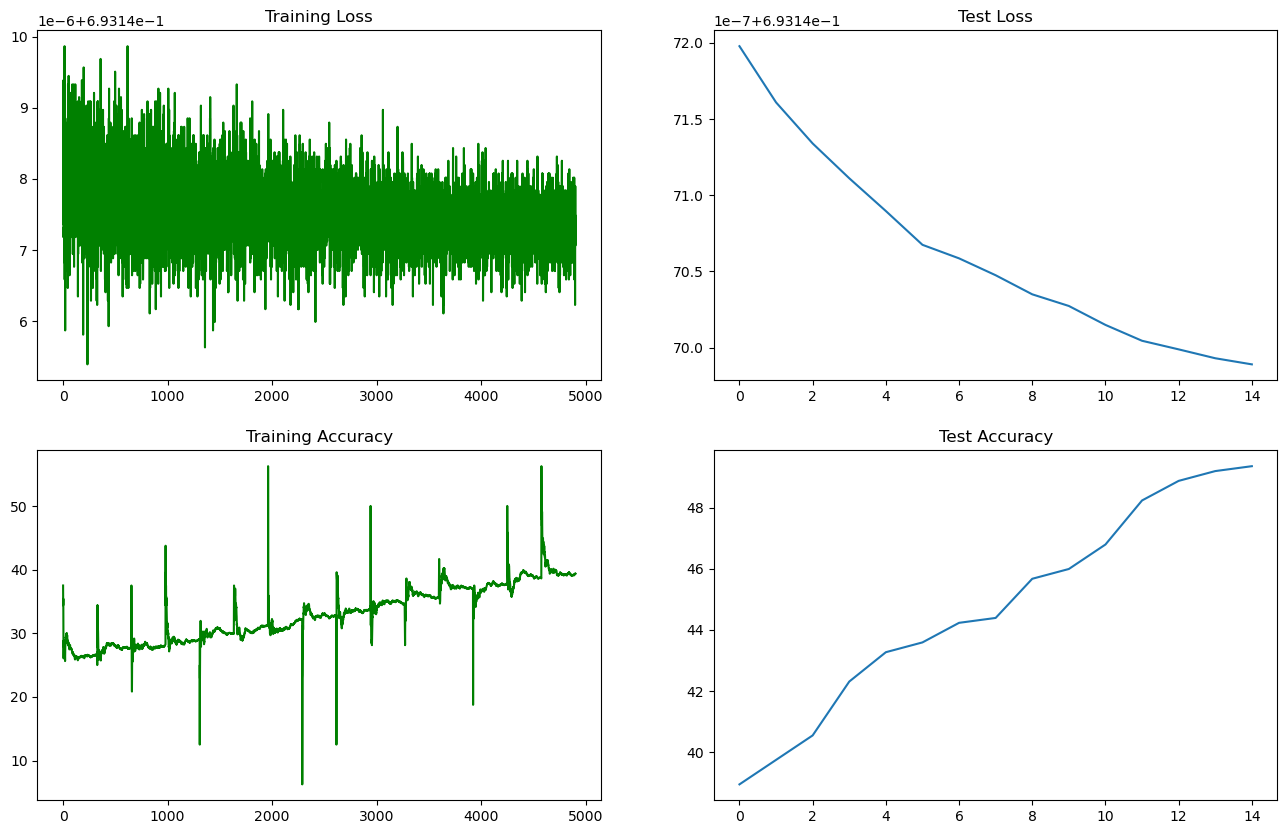

In [15]:
train_losses1 = [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_acc]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_acc]

fig, axs = plt.subplots(2, 2, figsize = (16,10))

axs[0,0].plot(train_losses1, color='green')
axs[0,0].set_title('Training Loss')

axs[1,0].plot(train_acc1, color='green')
axs[1,0].set_title('Training Accuracy')

axs[0,1].plot(test_losses1)
axs[0,1].set_title('Test Loss')

axs[1,1].plot(test_acc1)
axs[1,1].set_title('Test Accuracy')


- **Training Loss** `(Loss={loss.item()})`: This is the value of the loss function on the training dataset. The loss function measures how well the model is performing. During training, the goal is to minimize this value. *How well the model is performing on the training data.* (x axis : mins)

- **Training Accuracy** `(Accuracy={float(100*correct/proccessed):.2f})`: This is the accuracy of your model on the training dataset. It's the percentage of correctly predicted samples out of the total number of training samples. *Percentage of correct predictions on the training data.* (x axis : mins)

- **Test Loss** `(Average loss: {:.4f})`: This is the value of the loss function on the test dataset. It indicates how well your model generalizes to *unseen* data. During training, you don't want just the training loss to decrease; **you also want the test loss to be low, showing that the model is not overfitting**. *How well the model generalizes to new, unseen data.* (x axis : epochs)

- **Test Accuracy** `(Accuracy: {}/{} ({:.2f}%))`: This is the accuracy of your model on the test dataset. It's the percentage of correctly predicted samples out of the total number of test samples. *Percentage of correct predictions on the test data.* (x axis : epochs)

Looking at the plots we can see the following:
- `Training Loss`: Although very noisy and extremely unstable, it seems to be decreasing.
- `Training Accuracy`: Was at $26.9\%$ at epoch 0, ended up at $39.37\%$ at epoch 14.
- `Test Loss`: Is almost steadily decreasing .
- `Test Accuracy`: Begun at $38.94\%$ at epoch 0, ended up at $49.36\%$ at epoch 14.

In general, although accuracy is increasing, it is quite low, so this means we need to do some variations to increase it.